In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using LM-BFGS with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each triplet of parameters $\alpha = (\beta, \gamma,m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip, arctan, exp, pi, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from matplotlib import colormaps
from scipy.interpolate   import CubicHermiteSpline
from scipy.sparse.linalg import LinearOperator
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

In [4]:
# Total population
n = 400
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we compute the smooth transformation $p_1 = \widehat{\rho}_{\mathsf e} + 4 \big(\sin(\widehat{\rho}_{\mathsf e}) - \sin(\rho_0) \big)$.

In [5]:
T  = 3                             # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Rates for ρ̂ₑ:
βₑ, γₑ, mₑ = 0.007, 0.1, 0.05
αₑ = asarray([βₑ, γₑ, mₑ])

In [7]:
print('Basic reproduction number:', n*βₑ/(γₑ+mₑ))

Basic reproduction number: 18.666666666666664


In [8]:
def SIRD(t, z, β,γ,m):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [9]:
sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ, mₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [10]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIRD(0,ρ̂ₑ,βₑ,γₑ,mₑ))

Apply smooth transformation:

In [11]:
p_1 = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

Now we split the integral $[0,T]$ into $k$ periods and compute the rolling average of $p_1$ on each subinterval yielding a vector:
\begin{align*}
    (p_2)_i = \int\limits_{t_{i}}^{t_{i+1}} \frac{p_1}{t_{i+1} - t_i} \, \mathrm{d} s  \qquad \qquad \forall i \in [0:k-1].
\end{align*}

In [12]:
from scipy.integrate import quad_vec

In [13]:
SmoothVar = lambda t: sol.sol(t) + 4 * sin(sol.sol(t) - 4 * sin(ρ̂ₑ[:,0]) )

In [14]:
num_subintervals = 50
t_values = np.linspace(0, T, num_subintervals + 1)

In [15]:
IntQUADPACK = [quad_vec(SmoothVar, t_values[i], t_values[i+1], full_output=False)   for i in range(num_subintervals)]
averages    = asarray([IntQUADPACK[i][0]    for i in range(num_subintervals)]) / ( t_values[1] - t_values[0] )
print('Maximum integration error estimate: {0:.2e}'.format(asarray([IntQUADPACK[i][1]    for i in range(num_subintervals)]).max()) )

Maximum integration error estimate: 8.97e-09


Now let's keep monotony of the function: (a) susceptibles cannot increase, (b) recovered cannot decrease, (c) infected cannot decrease until the peak is reached.

In [16]:
MonAv = averages.copy()
for i in range(1,num_subintervals):
    # Susceptible
    if MonAv[i,0] > MonAv[i-1,0]:
        MonAv[i,0] = MonAv[i-1,0]
    # Recovered
    if MonAv[i,2] < MonAv[i-1,2]:
        MonAv[i,2] = MonAv[i-1,2]
    # Infected
    idx_cut = np.digitize(Tₑ[np.argmax(ρ̂ₑ.T[:,1])], t_values) - 1    # Compute maximal increase (based on original smooth curve)
    if i <= idx_cut:
        if MonAv[i,1] < MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]
    else:
        if MonAv[i,1] > MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]

Now produce an upper semicontinuous function from the average:
\begin{align*}
    \hat{\rho} = p_3(t) = \sum_{i=0}^{k-1} (p_2)_i \iota_{ t_{i+1} \leq t < t_i  } + (p_2)_{k-1} \iota_{t=T}.
\end{align*}

In [17]:
def averaged_ρ(t):
    # Ensure t is within the defined interval
    if np.any(t < 0) or np.any(t > T):
        raise ValueError("Some t values are out of bounds!")
    
    # Find the subinterval index:
    idx = np.digitize(t, t_values) - 1
    
    # Handle the edge case where t == T
    idx = np.where(t == T, len(MonAv) - 1, idx)
    
    return MonAv[idx].T

In [18]:
ρ̂ = averaged_ρ(Tₑ)
ρ̄ = averaged_ρ      # Functional representation

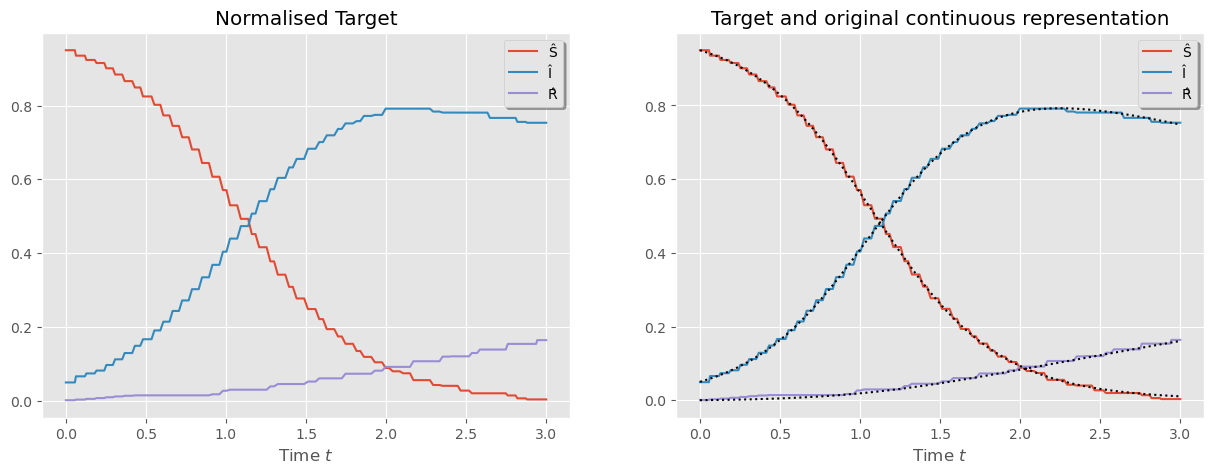

In [19]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, ρ̂.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Target and original continuous representation')
plt.show()

## Create a given state

In [20]:
# Give a random initial control
α = asarray([0.01,0.02,0.1])

In [21]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = ρ_sol.sol    # CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

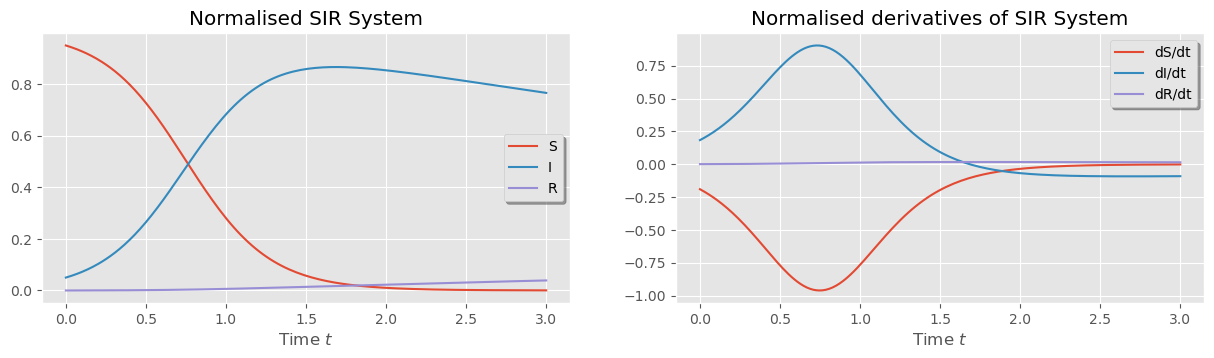

In [22]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIRD(0.0, ρ, α[0], α[1], α[2])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [23]:
def Adjoint(t, z, β,γ,m, ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [24]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,0.1, ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 446 function evaluations.


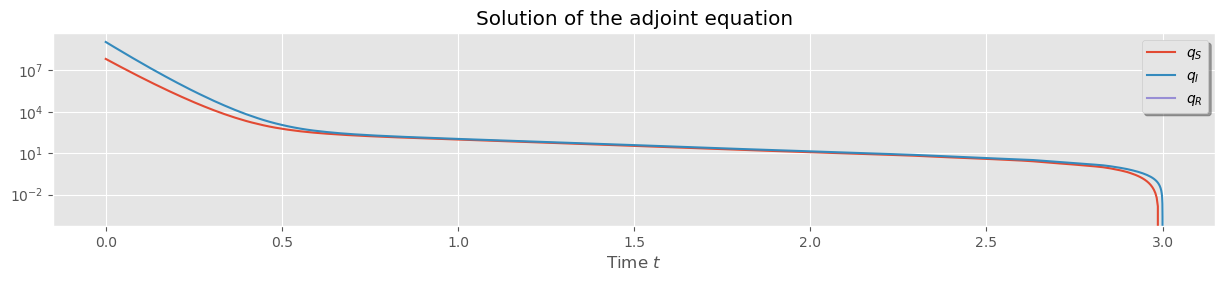

In [25]:
# Plot adjoint curves
plt.figure(figsize=(15,2.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 +m^2 ).
\end{align}

In [26]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,x=Tₑ).sum() + θ * (α**2).sum())
# This one can be two times faster:
#def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson(((ρ-ρ̂)**2).sum(0),x=Tₑ) + θ * (α**2).sum())

In [27]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [28]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+3) ))

As an example, the distance between ρ and ρ̂ is 11594.7031.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} = \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta,
    \qquad
    \frac{\partial f}{\partial \gamma} = \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma,
    \qquad
    \frac{\partial f}{\partial m} = \int\limits_0^T -I q_I  \, \dif t  + \theta m. 
\end{align}

In [29]:
q = solₛ.y[:,::-1]

In [30]:
θ = 0.1
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])  + θ * α
display(df.tolist())

[251759367575.16516, -716288666.3496727, -716259675.1077482]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [31]:
θ = 0.0

In [32]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [33]:
T_s  = lambda s: np.where(s > 0.0, s**2, 0.0)
dT_s = lambda s: np.where(s > 0.0, 2*s, 0.0)

In [34]:
rt = 1e-3
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    #f += 1e+3 * T_s(α[1] + α[2] - 1.0)
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIRD(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    #df += 1e+3 * dT_s(α[1] + α[2] - 1.0)
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0

    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF  = asarray([simpson(ρₐ[0]*ρₐ[1] * (q̂[1]-q̂[0]), x=Tₑ), simpson(ρₐ[1] * (q̂[2]-q̂[1]), x=Tₑ),  -simpson(ρₐ[1] * q̂[1], x=Tₑ)])
    dF /= (n**2) if scaling else 1.0
    dF += (θ * α)

    return asarray(f), dF

---

In [35]:
# Optimal point should be around
# 0.007, 0.7, 0.3
# So we evaluate around this point

In [34]:
# Coarse evaluations (takes a long time)
nβ, nγ, nm = 41, 41, 31
Misfit = zeros([nβ, nγ, nm])
β_axis = linspace(0.001,0.15,nβ)
γ_axis = linspace(0.1,1,nγ)
m_axis = linspace(0.1,1,nm)
for (i,β) in enumerate(β_axis):
    #print(i)
    for (j,γ) in enumerate(γ_axis):
        for (k,m) in enumerate(m_axis):
            Misfit[i,j,k] = obj_eval_a( asarray([β,γ,m]) ).item()

In [35]:
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)
M_0, β_0, γ_0, m_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]],    m_axis[i_0[2]]
print('Smallest objective found in the mesh: {0:.4e} with (β,γ,m): ({1:.4f},{2:.4f},{3:.4f})'.format(M_0,β_0,γ_0, m_0))

Smallest objective found in the mesh: 7.2703e-03 with (β,γ,m): (0.0084,0.7750,0.5800)


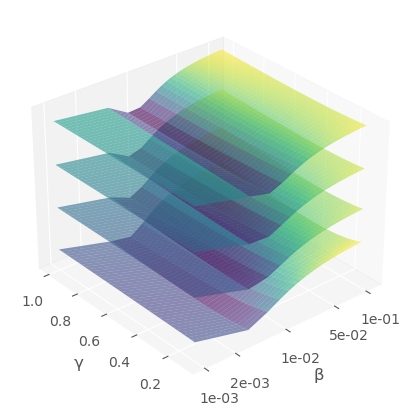

In [36]:
# Create grid of (β,γ)
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')

# Create a 3D plot
fig = plt.figure( figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces for each z value
for k in [0,10,20,30]:
    # Create a surface plot for each z value and stack them vertically
    ax.plot_surface(np.log(X_c), Y_c, Misfit[:,:,k]+k/10, cmap='viridis', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('β')
ax.set_ylabel('γ')

#ax.set_zlabel('Z (graphically scaled)')
#ax.set_title('Stacked Surface Plots for varying $m$')

ax.view_init(elev=30, azim=230)
ax.set_box_aspect((2, 2, 1.5))

# Set the ticks
ax.set_xticks([-6.9,-6,-4.5,-3,-2]);    #ax.set_yticks([-2.3,-1.5,-0.5,0])
ax.set_xticklabels([f'{val:.0e}' for val in np.exp(ax.get_xticks())])
#ax.set_yticklabels([f'{val:.0e}' for val in np.exp(ax.get_yticks())])
ax.set_zticks([])
ax.set_facecolor('xkcd:white')
plt.show()

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $x_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i} 
            \leq \xi_k \lor x_{k,i} \geq 1 -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \xi_k < x_{k,i} < 1 -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{1 , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i}     & \text{if } x_{k,i} \leq \xi_k,  \\
        1 - x_{k,i} & \text{if } x_{k,i} \geq 1 - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ 0, \min\left\{ 1, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [36]:
# Initial point
β, γ, m = α = rng(80).uniform(0,1,3)
α[0] *= 0.1
α, γ + m

(array([0.07364913, 0.0184188 , 0.03663371]), 0.05505250620295099)

In [37]:
dim = 3            # dimension of the parameter to optimise 

In [38]:
θ = 0.0
obj_eval_a(α)

array(0.63726528)

A Limited Memory BFGS method is used. The matrices will be constantly updated.

In [39]:
'''Functions needed for LM operations'''
def Limited():
    def B_eval(W,MI,dk):
        db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
    def BA_eval(W,MI,Uk,dUk):
        db = zeros(dim, dtype='float')
        db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
    def BAT_eval(W,MI,Uk,dUk):
        db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
        return db
    def H_eval(WH,MH,dk):
        db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
    def HA_eval(WH,MH,Uk,dUk):
        db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
        return db
    def HAT_eval(WH,MH,Uk,dUk):
        db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
    return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval

In [40]:
def LBFGS(S,Y,SY, θ):
    W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
    MI  = inv(MM)
    WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
    MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
    return MI, MH, W, WH
def LSR1(S,Y,SY, θ):
    W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
    while np.linalg.det(MM) == 0.0:
        θ *= 0.5
        W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
    MI = inv(MM)
    WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
    MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
    return MI, MH, W, WH

We will run the problem for several regularisers:

In [41]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,1)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00])

In [42]:
#α *= 0.1
#from scipy.optimize._minimize import minimize_scalar

In [43]:
obj_eval_a(np.asarray([βₑ,γₑ,mₑ]))

array(0.00018795)

In [44]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    
    '''
    
        ********************************* AS-LM-BFGS algorithm *********************************
        
    '''
    Method = 'BFGS'
    
    
    '''Reserve memory'''
    cLM   = 1
    S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
    SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    
    ''' Create structures to store information from iterates '''
    save_iter = True            # Do we store information for every iteration?
    if save_iter:
        ei_keys = ['it', 'obj', 'time', 'β', 'γ','m', 'df_β', 'df_γ', 'df_m', 't_k', 'norms']
        ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']

        every_iter = {a:[] for a in ei_keys}
        every_iter['norms'] = {a:[] for a in ei_norm}


    save_critical = True        # Do we store information for every "critical" iteration?
    critical = 10               # An iteration is critical after some iterations
    if save_critical:
        ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

        every_critical = {a:[] for a in ec_keys}
    
    
    ''' Initial point '''
    xₖ = asarray(α).copy()      # Be aware this α is different from αᵪ below
    
    
    ''' Algorithm parameters'''
    # All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    ''' Setting TR parameters '''
    αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
    ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
    #ρᵪ = [1e-2,0.5]
    bᵪ = 1.0                         # Box upper bound
    σᵪ = 0.0003                       # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
    ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
    δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
    cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
    pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
    mᵪ = 5                           # Memory size for LM
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    Δᵪ = [1.0, 2.0, 1e-13, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_Ha    = 1e-11                 # Absolute Himmeblau criteria
    εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria
    
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    #print(fₖ)
    Obj_Res = [];              Obj_Res.append(fₖ.tolist())
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = 100
    
    
    timed = 0.0              # Clock

    ''' Run algorithm for the given settings '''
    for kᵪ in range(Max_It):

        # Print header of table
        if kᵪ == 0:
            print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|{6:^11s}|'.format('#','β', 'γ', 'm', 'f(α)',
                                                                        'ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
            print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

            print('–'*121)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ-1 )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['m'].append( xₖ[2] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['df_m'].append( dfₖ[2] )
                every_iter['t_k'].append( 0.0 )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(2**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/2 )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            if kᵪ % critical == 0:
                every_critical['it'].append( kᵪ-1 )
                every_critical['obj'].append( fₖ )
                every_critical['time'].append( timed )
                every_critical['|df|_2'].append( norm(dfₖ)/(dim**0.5) )
                every_critical['|df|_max'].append( norm(dfₖ,np.inf) )

            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], xₖ[2], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )

        # *************** #
        # Stationarity test
        if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
            print('Optimality reached.')
            break

        it_time = time.time()                                # Clock

        # *************** #
        # 1. TR radii update
        Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
        Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

        # *************** #
        # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
        ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
        Iₖ = where( (xₖ > ξᵪ) & (xₖ < bᵪ-ξᵪ) )[0]             # Inactive set (13)
        Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)

        # *************** #
        # 3. Trust-Region Subproblem

        # ––––––––– #
        # Limited memory matrix
        if Method == 'BFGS':
                     MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
        else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
        #
        B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()

        # ––––––––– #
        # Gradient scaling
        γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
        #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))

        # ––––––––– #
        # Subvector of estimated active elements
        vₖ      = full(dim, np.nan)                           # Initialise
        Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
        vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
        vAₖ     = vₖ[Aₖ]                                       # Extract info

        # ––––––––– #
        # Reserve memory for TR direction
        dTRₖ = ones(dim)


        # ––––––––– #
        # TR iteration
        kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
        while 1 != 2:
            # ///// #
            # 3.a Projected Gradient Direction
            #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
            wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
            dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ

            # ///// #
            # Active direction [prevent empty division]
            wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
            dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])

            # ///// #
            # 3.b Reduced TR subproblem in inactive set
            if Iₖ.size > 0:
                #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
                #dd[Ak] += dAk                                   # considered and comment c below.

                BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
                #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered

                def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
                BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
                def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
                def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem

                A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
                B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
                #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
                #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

                InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                           bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
                dIₖ = InactiveSubProb.x
            else:
                dIₖ = array([])

            # ///// #
            # Projected TR Direction [from LM and active sets]
            dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
            dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)


            # *************** #
            # 4. Search direction
            # ///// #
            if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
            else:
                # ** Optimize only knowing objective ** #
                def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
                # ** Optimize with gradient information ** #
                '''def a_fun(t):
                    ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                    return ob, array( der.dot(dGₖ - dTRₖ) )'''
                
                # Optimise one dimensional convex combination between the obtained directions
                OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = False, 
                                            bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 10}) #, 'disp':1})
                #OneDimensionalCC_2 = minimize_scalar(a_fun, method='bounded', bounds = [0.0, 1.0]) #, options={'disp':1} )
                #print(OneDimensionalCC.x, OneDimensionalCC.nfev)
                #print(OneDimensionalCC_2.x, OneDimensionalCC_2.nfev)

                # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
                #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
                if OneDimensionalCC.status != 0:
                    #print(OneDimensionalCC)
                    #plt.plot(np.linspace(0,1,20), [a_fun(t) for t in np.linspace(0,1,20) ])
                    #plt.show()
                    print('\033[1;31;47m * \x1b[0m', end = ' ')    
                tₖ = OneDimensionalCC.x.item()

            # ///// #
            # The final direction is the best linear combination of the projected gradient with the LM direction
            dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ


            # *************** #
            # 5. Test the Search Direction
            # ///// #
            Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
            rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio

            # Check line search condition
            ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
            # Test if reduction ratio is accepted
            AcceptReduction = (rₖ >= ρᵪ[0])

            # If both conditions are satisfied, then accept step and continue to the next iteration
            if AcceptReduction and ArmijoGoldstein:
                if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
                break
            else:
                # TR radius is decreased
                if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                # Update counter
                kᵢₙₙₑᵣ += 1
                # Decrease TR radius 
                Δᵪ[-1] *= αᵪ[0]
                # Print updated radius
                print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
                # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
                if Δᵪ[-1] < Δᵪ[2]:
                    print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                    break

                    
                    
                    
        # ––––––––– #
        # TR radius stopping criteria
        if Δᵪ[-1] < Δᵪ[2]:
            print('\033[10;42;1m  TR-min  \033[10;42;1m')
            break

        # ––––––––– #
        # Updating info
        sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
        yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
        xₖ += dₖ                                              # Store xₖ + dₖ

        # ––––––––– #
        # Himmeblau stopping criteria
        if abs(fₖ) > εᵪ_HCond:
            if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
                print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break
        else:
            if abs(fₖ - Tfₖ) < εᵪ_Ha:
                print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
                fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                break

        # ––––––––– #
        # Updating info
        fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
        yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
        #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]

        # ––––––––– #
        # Test for TR expansion
        if rₖ >= ρᵪ[1]:
            Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
        else:
            Δᵪ[0] = Δᵪ[-1]


        # ––––––––– #
        # Update of LM info
        ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]

        # Powell correction
        if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
            # print('\033[0;34;48m [P] \x1b[0m')
            əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
            yₖ *= əᵪ
            yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)

        # Add LM updates if curvature sₖᵀyₖ is not too small
        if ϕᵪ[0] > εᵪ_LM:
            # print('\033[5;34;46m [C] \x1b[0m')
            cLM = min(S.shape[1], mᵪ)            # Current LM size
            if cLM < mᵪ:                         # If size is small, add column with secant information
                S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                cLM  += 1 
                SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
            else:                                # If size is too large, drop first column
                S = append(S[:,1:], sₖ[:,None], axis=1)
                Y = append(Y[:,1:], yₖ[:,None], axis=1)

            #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest

        # If curvature is too small, we can reset the LM objects
        if ϕᵪ[1] < εᵪ_LM:
            # print('\033[7;34;48m [R] \x1b[0m')
            cLM   = 1
            S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)


        # *************** #
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time

        # Report current status
        if save_iter:
            every_iter['it'].append( kᵪ )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( xₖ[0] )
            every_iter['γ'].append( xₖ[1] )
            every_iter['m'].append( xₖ[2] )
            every_iter['df_β'].append( dfₖ[0] )
            every_iter['df_γ'].append( dfₖ[1] )
            every_iter['df_m'].append( dfₖ[2] )
            every_iter['t_k'].append( tₖ )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/3 )
            every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
            every_iter['norms']['min'].append( abs(dfₖ).min() )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(dfₖ)/(3**0.5) )
            every_critical['|df|_max'].append( norm(dfₖ,np.inf) )


        # Store objective [might not be needed anymore but it's handy]
        Obj_Res.append(fₖ.tolist())

        if kᵪ % critical == 0:
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], xₖ[2], fₖ,
                                                                norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
            print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))


        if kᵪ == (Max_It - 1):
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')

    # Measure final time
    end = time.time();    timed += end - it_time
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    


    # Recover dataframe from results
    every_iter['obj'] = asarray(every_iter['obj'])
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


  #  |     β     |     γ     |     m     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 7.365e-02 | 1.842e-02 | 3.663e-02 | 6.373e-01 | 1.168e+00 | 1.519e+00 |
 TR-radius:  5.000e-01  2.500e-01 
  0  | 7.044e-03 | 7.510e-02 | 8.178e-02 | 9.167e-04 | 1.079e-01 | 1.817e-01 |  3  |  0  | 0.952  | 5.683e-02 |   0.132   
 TR-radius:  2.500e-01  1.250e-01  6.250e-02  3.125e-02  1.562e-02  7.812e-03  3.906e-03 
 TR-radius:  7.812e-03  3.906e-03  1.953e-03 
 TR-radius:  1.953e-03  9.766e-04  4.883e-04 
 TR-radius:  4.883e-04  2.441e-04  1.221e-04  6.104e-05  3.052e-05  1.526e-05  7.629e-06  3.815e-06  1.907e-06  9.537e-07  4.768e-07  2.384e-07  1.192e-07  5.960e-08  2.980e-08  1.490e-08  7.451e-09  3.725e-09  1.863e-09  9.313e-10  4.657e-10  2.328e-10  1.164e-10  5.821e-11  2.910e-1

 TR-radius:  4.768e-07 
 TR-radius:  2.384e-07  1.192e-07 
 TR-radius:  5.960e-08 
 TR-radius:  2.980e-08  1.490e-08 
 TR-radius:  7.451e-09 
 10  | 7.059e-03 | 7.604e-02 | 8.278e-02 | 8.905e-04 | 3.335e-02 | 4.157e-02 |  3  |  0  |   1    | 1.252e-10 |   0.764   
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 20  | 7.059e-03 | 7.604e-02 | 8.278e-02 | 8.905e-04 | 3.292e-02 | 4.052e-02 |  3  |  0  |   1    | 1.235e-10 |   1.02    
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 30  | 7.059e-03 | 7.604e-02 | 8.278e-02 | 8.905e-04 | 3.250e-02 | 3.950e-02 |  3  |  0  |   1    | 1.219e-10 |   1.27    
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radius:  7.451e-09 
 TR-radiu

 20  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.158e-01 | 8.727e-01 |  3  |  0  |   1    | 1.921e-09 |   0.526   
 30  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.166e-01 | 8.741e-01 |  3  |  0  |   1    | 1.924e-09 |   0.581   
 40  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.173e-01 | 8.755e-01 |  3  |  0  |   1    | 1.927e-09 |   0.643   
 50  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.181e-01 | 8.769e-01 |  3  |  0  |   1    | 1.930e-09 |   0.695   
 60  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.189e-01 | 8.783e-01 |  3  |  0  |   1    | 1.933e-09 |   0.752   
 70  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.197e-01 | 8.797e-01 |  3  |  0  |   1    | 1.936e-09 |   0.808   
 80  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.205e-01 | 8.811e-01 |  3  |  0  |   1    | 1.936e-09 |   0.861   
 90  | 7.382e-03 | 1.306e-01 | 1.250e-01 | 7.464e-03 | 5.213e-01 | 8.825e-01 |  3  |  0  |   1    | 1.936e-09 |   0.913   
  Maxiter  

Alg

In [45]:
βₑ, γₑ, mₑ

(0.007, 0.1, 0.05)

In [46]:
θ = 0.0
obj_eval(np.asarray([βₑ, γₑ, mₑ])), θ

((array(0.00018795), array([ 0.06142471, -0.00836656, -0.00302224])), 0.0)

In [47]:
obj_eval(Stats[['β','γ','m']].values[0])

(array(0.00084416), array([ 0.21161375, -0.02502085,  0.0192568 ]))

In [48]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,4,0.000844,0.419682,0.007075,0.079146,0.085958,0.211614,-0.025021,0.019257,0.224315,0.085297,0.123528,0.211614,0.019257
1.000000e-07,5,0.000843,0.490320,0.007078,0.079401,0.086206,0.721882,-0.025307,0.018195,0.500000,0.255128,0.417167,0.721882,0.018195
1.000000e-06,4,0.000843,0.533517,0.007079,0.079333,0.086130,0.516800,-0.025155,0.018238,0.500000,0.186731,0.298913,0.516800,0.018238
1.000000e-05,3,0.000847,0.382796,0.007080,0.079467,0.086466,1.703959,-0.027701,0.015800,0.353506,0.582487,0.983954,1.703959,0.015800
1.000000e-04,99,0.000891,3.102756,0.007059,0.076042,0.082784,0.035490,-0.038664,0.010648,1.000000,0.028267,0.030918,0.038664,0.010648
1.000000e-03,7,0.001053,0.624384,0.007083,0.075634,0.091106,0.385430,-0.028242,0.021802,0.284231,0.145158,0.223480,0.385430,0.021802
1.000000e-02,99,0.007464,0.962702,0.007382,0.130642,0.124994,0.883767,0.150943,0.116751,1.000000,0.383820,0.522002,0.883767,0.116751
1.000000e-01,99,0.008822,0.969088,0.007380,0.130314,0.124527,0.408820,0.163546,0.130795,1.000000,0.234387,0.265197,0.408820,0.130795
1.000000e+00,5,0.006576,0.529008,0.006929,0.058811,0.071801,0.656147,-0.052078,0.039377,0.163487,0.249201,0.380697,0.656147,0.039377


In [49]:
#CMap = get_cmap('Wistia')
CMap = colormaps['YlGnBu']
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

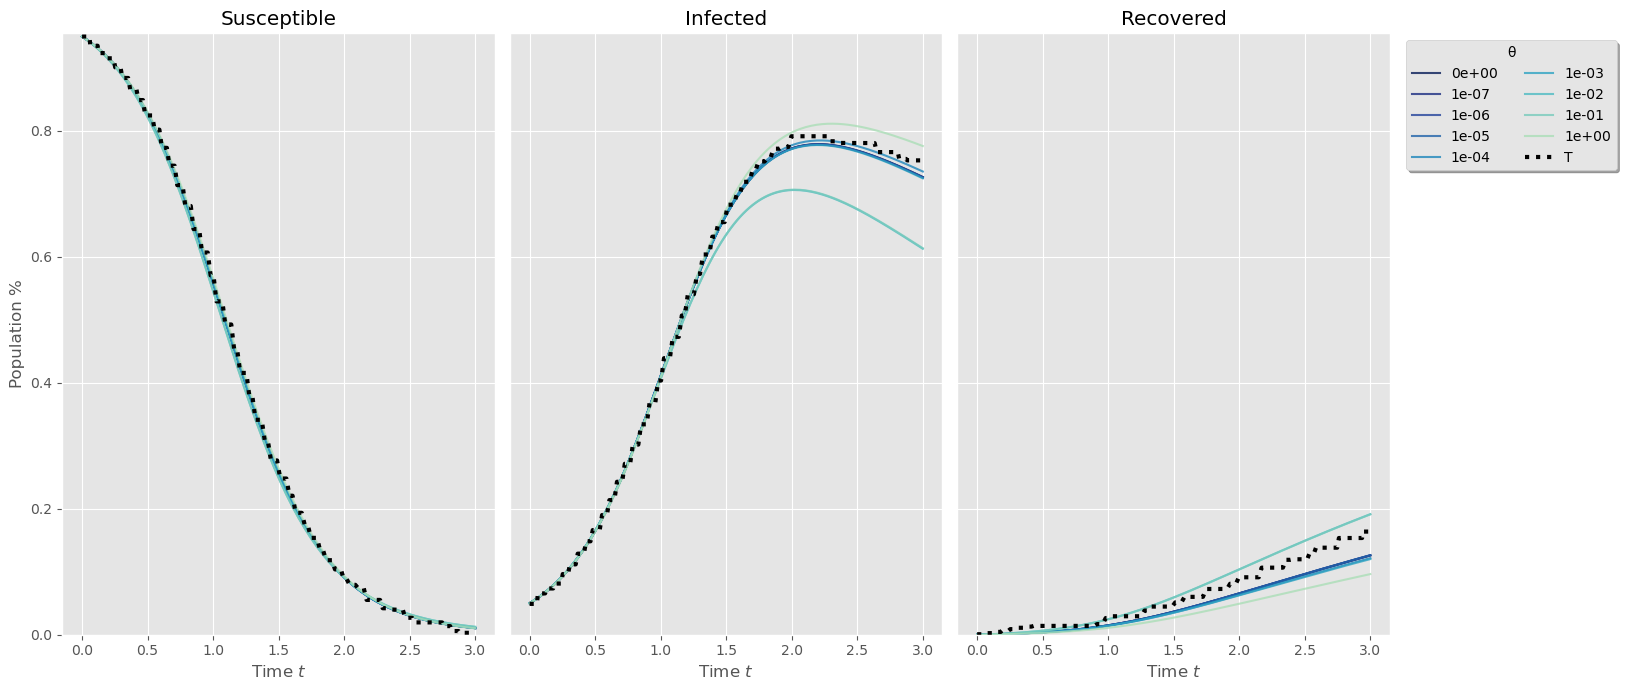

In [50]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – BFGS.pdf', bbox_inches='tight', pad_inches=0)

[]

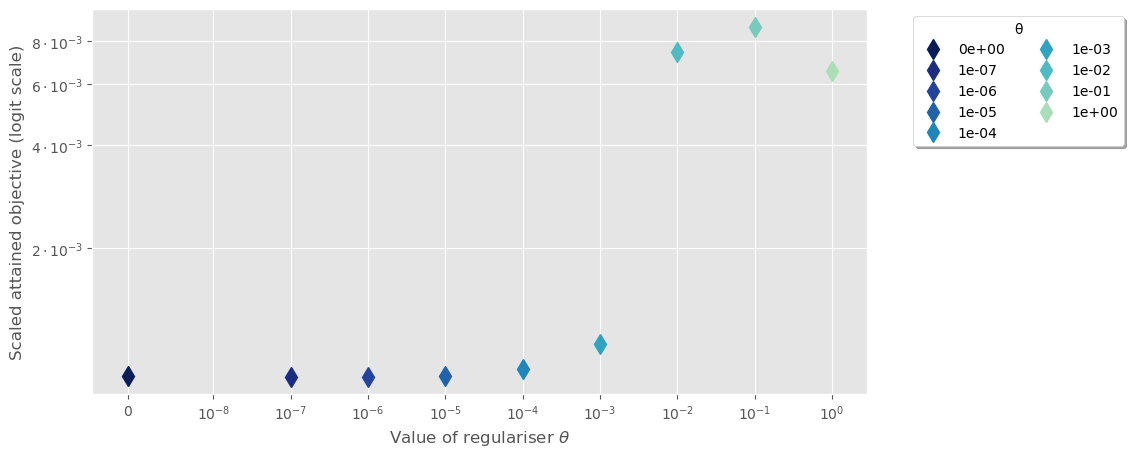

In [51]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

---

In [52]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,4,0.000844,0.419682,0.007075,0.079146,0.085958,0.211614,-0.025021,0.019257,0.224315,0.085297,0.123528,0.211614,0.019257
1.000000e-07,5,0.000843,0.490320,0.007078,0.079401,0.086206,0.721882,-0.025307,0.018195,0.500000,0.255128,0.417167,0.721882,0.018195
1.000000e-06,4,0.000843,0.533517,0.007079,0.079333,0.086130,0.516800,-0.025155,0.018238,0.500000,0.186731,0.298913,0.516800,0.018238
1.000000e-05,3,0.000847,0.382796,0.007080,0.079467,0.086466,1.703959,-0.027701,0.015800,0.353506,0.582487,0.983954,1.703959,0.015800
1.000000e-04,99,0.000891,3.102756,0.007059,0.076042,0.082784,0.035490,-0.038664,0.010648,1.000000,0.028267,0.030918,0.038664,0.010648
1.000000e-03,7,0.001053,0.624384,0.007083,0.075634,0.091106,0.385430,-0.028242,0.021802,0.284231,0.145158,0.223480,0.385430,0.021802
1.000000e-02,99,0.007464,0.962702,0.007382,0.130642,0.124994,0.883767,0.150943,0.116751,1.000000,0.383820,0.522002,0.883767,0.116751
1.000000e-01,99,0.008822,0.969088,0.007380,0.130314,0.124527,0.408820,0.163546,0.130795,1.000000,0.234387,0.265197,0.408820,0.130795
1.000000e+00,5,0.006576,0.529008,0.006929,0.058811,0.071801,0.656147,-0.052078,0.039377,0.163487,0.249201,0.380697,0.656147,0.039377


In [53]:
Stats.to_pickle('Outputs/Regularisation – LMBFGS - Final.pkl') # To read back use pd.read_pickle(file_name)

In [54]:
print(np.around(Stats,6)[['it','time','β','γ','m','obj','norms-ℓ_2']].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & it & time & β & γ & m & obj & norms-ℓ_2 \\
\midrule
0.000000 & 4 & 0.419682 & 0.007075 & 0.079146 & 0.085958 & 0.000844 & 0.123528 \\
0.000000 & 5 & 0.490320 & 0.007078 & 0.079401 & 0.086206 & 0.000843 & 0.417167 \\
0.000001 & 4 & 0.533517 & 0.007079 & 0.079333 & 0.086130 & 0.000843 & 0.298913 \\
0.000010 & 3 & 0.382796 & 0.007080 & 0.079467 & 0.086466 & 0.000847 & 0.983954 \\
0.000100 & 99 & 3.102756 & 0.007059 & 0.076042 & 0.082784 & 0.000891 & 0.030918 \\
0.001000 & 7 & 0.624384 & 0.007083 & 0.075634 & 0.091106 & 0.001053 & 0.223480 \\
0.010000 & 99 & 0.962702 & 0.007382 & 0.130642 & 0.124994 & 0.007464 & 0.522002 \\
0.100000 & 99 & 0.969088 & 0.007380 & 0.130314 & 0.124527 & 0.008822 & 0.265197 \\
1.000000 & 5 & 0.529008 & 0.006929 & 0.058811 & 0.071801 & 0.006576 & 0.380697 \\
\bottomrule
\end{tabular}



In [55]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval(α):                  # ** Eval j and  j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=False, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    
    return asarray(f), df

In [56]:
Stats  = None
States = dict()
 
for θ in Regularisers:
    # Run algorithm
    for i in [0,1,2]:
        if i == 0:
            # Initial point
            α = rng(80).uniform(0,1,3)
            α[0] *= 0.1
            buf_it = []
            buf_ti = []
        else: 
            α = xₖ
            
            
        print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')

        '''

            ********************************* AS-LM-BFGS algorithm *********************************

        '''
        Method = 'BFGS'


        '''Reserve memory'''
        cLM   = 1
        S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
        SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

        #S = np.eye(dim,    dtype = 'float')[:,:1];    Y = S.copy();    mm = S.shape[1];    SY = empty([mm,mm], dtype = 'float')
        #O = zeros([mm,mm], dtype = 'float')


        ''' Create structures to store information from iterates '''
        save_iter = True            # Do we store information for every iteration?
        if save_iter:
            ei_keys = ['it', 'obj', 'time', 'β', 'γ','m', 'df_β', 'df_γ', 'df_m', 't_k', 'norms']
            ei_norm = ['ℓ_1', 'ℓ_2', 'max', 'min']

            every_iter = {a:[] for a in ei_keys}
            every_iter['norms'] = {a:[] for a in ei_norm}


        save_critical = True        # Do we store information for every "critical" iteration?
        critical = 1               # An iteration is critical after some iterations
        if save_critical:
            ec_keys = ['it', 'obj', 'time', '|df|_2', '|df|_max']

            every_critical = {a:[] for a in ec_keys}


        ''' Initial point '''
        xₖ = asarray(α).copy()      # Be aware this α is different from αᵪ below


        ''' Algorithm parameters'''
        # All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
        ''' Setting TR parameters '''
        αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
        ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
        #ρᵪ = [1e-2,0.5]
        ρᵪ = [0.08,0.1]
        bᵪ = 1.0                         # Box upper bound
        σᵪ = 0.003                       # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
        ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
        δᵪ = 0.99 * 0.5                  # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
        cᵪ = 0.01 #1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
        pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
        mᵪ = 5                           # Memory size for LM
        θᵪ = 1.2                         # Initial weight for basic Hessian approximation
        Δᵪ = [1.0, 0.1, 1e-13, 1.0]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

        ''' Additional tolerances '''
        εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
        εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
        εᵪ_Ha    = 1e-11                 # Absolute Himmeblau criteria
        εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria


        ''' Initial iteration (xₒ, fₒ, dfₒ) '''
        fₖ, dfₖ  = obj_eval(xₖ)
        #print(fₖ)
        Obj_Res = [];              Obj_Res.append(fₖ.tolist())
        ''' Initial iteration counter and maximum number of iterations '''
        kᵪ      = 0;
        Max_It  = 50


        timed = 0.0              # Clock

        ''' Run algorithm for the given settings '''
        for kᵪ in range(Max_It):

            # Print header of table
            if kᵪ == 0:
                print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^11s}|{5:^11s}|{6:^11s}|'.format('#','β', 'γ', 'm', 'f(α)','ᵣ‖∇f(α)‖2','ᵣ‖∇f(α)‖∞'), end='')
                print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','ᵣ‖d‖2', 'Time'))

                print('–'*121)

                # Report initial iteration info
                if save_iter:
                    every_iter['it'].append( kᵪ-1 )
                    every_iter['obj'].append( fₖ )
                    every_iter['time'].append( timed )
                    every_iter['β'].append( xₖ[0] )
                    every_iter['γ'].append( xₖ[1] )
                    every_iter['m'].append( xₖ[2] )
                    every_iter['df_β'].append( dfₖ[0] )
                    every_iter['df_γ'].append( dfₖ[1] )
                    every_iter['df_m'].append( dfₖ[2] )
                    every_iter['t_k'].append( 0.0 )
                    # Store norms of gradient
                    every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(dim**0.5) )
                    every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                    every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                    every_iter['norms']['min'].append( abs(dfₖ).min() )
                if kᵪ % critical == 0:
                    every_critical['it'].append( kᵪ-1 )
                    every_critical['obj'].append( fₖ )
                    every_critical['time'].append( timed )
                    every_critical['|df|_2'].append( norm(dfₖ)/(dim**0.5) )
                    every_critical['|df|_max'].append( norm(dfₖ,np.inf) )

                print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₖ[0], xₖ[1], xₖ[2], fₖ,
                                                                    norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)) )

            # *************** #
            # Stationarity test
            if np.all(dfₖ[xₖ == 0.0] >= 0.0) & np.all(dfₖ[xₖ == 1] <= 0.0) & allclose(dfₖ[logical_and(xₖ>0.0, xₖ<1)], 0.0):
                print('Optimality reached.')
                break

            it_time = time.time()                                # Clock

            # *************** #
            # 1. TR radii update
            Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
            Δᵪ[-1] = Δᵪ[0]                                       # Δ̂

            # *************** #
            # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
            ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
            Iₖ = where( (xₖ >  ξᵪ) & (xₖ <  bᵪ-ξᵪ) )[0]            # Inactive set (13)
            Aₖ = where( (xₖ <= ξᵪ) + (xₖ >= bᵪ-ξᵪ) )[0]            # Active set (13)
            #print( ξᵪ, Iₖ)

            # *************** #
            # 3. Trust-Region Subproblem

            # ––––––––– #
            # Limited memory matrix
            if Method == 'BFGS':
                         MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
            else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
            #
            B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()

            # ––––––––– #
            # Gradient scaling
            γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
            #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))

            # ––––––––– #
            # Subvector of estimated active elements
            vₖ      = full(dim, np.nan)                           # Initialise
            Aˡᵪ, Aᵘᵪ = (xₖ <= ξᵪ), (xₖ >= bᵪ - ξᵪ)                 # Collect active indices
            vₖ[Aˡᵪ] = xₖ[Aˡᵪ];    vₖ[Aᵘᵪ] = bᵪ - xₖ[Aᵘᵪ]           # Lower and upper sides
            vAₖ     = vₖ[Aₖ]                                       # Extract info

            # ––––––––– #
            # Reserve memory for TR direction
            dTRₖ = ones(dim)
            #print(ξᵪ, Iₖ, vAₖ)

            # ––––––––– #
            # TR iteration
            kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
            while 1 != 2:
                # ///// #
                # 3.a Projected Gradient Direction
                #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
                wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
                dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ

                # ///// #
                # Active direction [prevent empty division]
                wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
                dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])

                # ///// #
                # 3.b Reduced TR subproblem in inactive set
                if Iₖ.size > 0:
                    #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
                    #dd[Ak] += dAk                                   # considered and comment c below.

                    BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
                    #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered

                    def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
                    BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
                    def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
                    def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem

                    A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
                    B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
                    #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
                    #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])

                    InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                               bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
                    dIₖ = InactiveSubProb.x
                    #print(InactiveSubProb)
                else:
                    dIₖ = array([])

                # ///// #
                # Projected TR Direction [from LM and active sets]
                dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
                dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)


                # *************** #
                # 4. Search direction
                # ///// #
                if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
                else:
                    # ** Optimize only knowing objective ** #
                    def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
                    # ** Optimize with gradient information ** #
                    '''def a_fun(t):
                        ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                        return ob, array( der.dot(dGₖ - dTRₖ) )'''

                    # Optimise one dimensional convex combination between the obtained directions
                    OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', jac = False, 
                                                bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 10}) #, 'disp':1})
                    #OneDimensionalCC_2 = minimize_scalar(a_fun, method='bounded', bounds = [0.0, 1.0]) #, options={'disp':1} )
                    #print(OneDimensionalCC.x, OneDimensionalCC.nfev)
                    #print(OneDimensionalCC_2.x, OneDimensionalCC_2.nfev)

                    # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
                    #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
                    if OneDimensionalCC.status != 0:
                        #print(OneDimensionalCC)
                        #plt.plot(np.linspace(0,1,20), [a_fun(t) for t in np.linspace(0,1,20) ])
                        #plt.show()
                        print('\033[1;31;47m * \x1b[0m', end = ' ')    
                    tₖ = OneDimensionalCC.x.item()

                # ///// #
                # The final direction is the best linear combination of the projected gradient with the LM direction
                dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ


                # *************** #
                # 5. Test the Search Direction
                # ///// #
                Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
                rₖ = (Tfₖ - fₖ)/( dfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio

                # Check line search condition
                ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
                # Test if reduction ratio is accepted
                AcceptReduction = (rₖ >= ρᵪ[0])

                # If both conditions are satisfied, then accept step and continue to the next iteration
                if AcceptReduction and ArmijoGoldstein:
                    if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
                    break
                else:
                    # TR radius is decreased
                    if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                    # Update counter
                    kᵢₙₙₑᵣ += 1
                    # Decrease TR radius 
                    Δᵪ[-1] *= αᵪ[0]
                    # Print updated radius
                    print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
                    # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
                    if Δᵪ[-1] < Δᵪ[2]:
                        print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                        break




            # ––––––––– #
            # TR radius stopping criteria
            if Δᵪ[-1] < Δᵪ[2]:
                print('\033[10;42;1m  TR-min  \033[10;42;1m')
                break

            # ––––––––– #
            # Updating info
            sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
            yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
            xₖ += dₖ                                              # Store xₖ + dₖ

            # ––––––––– #
            # Himmeblau stopping criteria
            if abs(fₖ) > εᵪ_HCond:
                if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
                    print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
                    fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                    break
            else:
                if abs(fₖ - Tfₖ) < εᵪ_Ha:
                    print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
                    fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
                    break

            # ––––––––– #
            # Updating info
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
            yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
            #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]

            # ––––––––– #
            # Test for TR expansion
            if rₖ >= ρᵪ[1]:
                Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
            else:
                Δᵪ[0] = Δᵪ[-1]


            # ––––––––– #
            # Update of LM info
            ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]

            # Powell correction
            if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
                # print('\033[0;34;48m [P] \x1b[0m')
                əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
                yₖ *= əᵪ
                yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)

            # Add LM updates if curvature sₖᵀyₖ is not too small
            if ϕᵪ[0] > εᵪ_LM:
                # print('\033[5;34;46m [C] \x1b[0m')
                cLM = min(S.shape[1], mᵪ)            # Current LM size
                if cLM < mᵪ:                         # If size is small, add column with secant information
                    S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                    cLM  += 1 
                    SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
                else:                                # If size is too large, drop first column
                    S = append(S[:,1:], sₖ[:,None], axis=1)
                    Y = append(Y[:,1:], yₖ[:,None], axis=1)

                #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest

            # If curvature is too small, we can reset the LM objects
            if ϕᵪ[1] < εᵪ_LM:
                #print('\033[7;34;48m [R] \x1b[0m')
                cLM   = 1
                S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
                SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

            # We can also reset memory
            if kᵪ % 100 == 0:
                #cLM   = 1
                #S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
                #SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
                S = np.eye(dim,    dtype = 'float')[:,:1];    Y = S.copy();    mm = S.shape[1];    SY = empty([mm,mm], dtype = 'float')
                O = zeros([mm,mm], dtype = 'float')

            # *************** #
            # Measure time up to this point!
            end = time.time()
            timed += end - it_time

            # Report current status
            if save_iter:
                every_iter['it'].append( kᵪ )
                every_iter['obj'].append( fₖ )
                every_iter['time'].append( timed )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['m'].append( xₖ[2] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['df_m'].append( dfₖ[2] )
                every_iter['t_k'].append( tₖ )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ)/(3**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/3 )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            if kᵪ % critical == 0:
                every_critical['it'].append( kᵪ )
                every_critical['obj'].append( fₖ )
                every_critical['time'].append( timed )
                every_critical['|df|_2'].append( norm(dfₖ)/(3**0.5) )
                every_critical['|df|_max'].append( norm(dfₖ,np.inf) )


            # Store objective [might not be needed anymore but it's handy]
            Obj_Res.append(fₖ.tolist())

            if kᵪ % critical == 0:
                print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1], xₖ[2], fₖ,
                                                                    norm(dfₖ)/(dim**0.5), norm(dfₖ, np.inf)), end='')
                print('{0:^5d}|{1:^5d}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size, Iₖ.size,tₖ,norm(dₖ)/(dim**0.5), timed))


            if kᵪ == (Max_It - 1):
                print('\033[10;41;1m  Maxiter  \033[10;41;1m')

        # Measure final time
        end = time.time();    timed += end - it_time
        print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
        print('\x1b[0m')
        
        if (loc_it := every_iter['it'][-1]) <= 0:
            if loc_it == 0:
                buf_it.append( 1 )
        else:
            buf_it.append( loc_it + 1 )
        
        buf_ti.append(timed)
    
    every_iter['it'][-1] = sum(buf_it)
    every_iter['time'][-1] = sum(buf_ti)


    # Recover dataframe from results
    every_iter['obj'] = asarray(every_iter['obj'])
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


  #  |     β     |     γ     |     m     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 7.365e-02 | 1.842e-02 | 3.663e-02 | 6.373e-01 | 1.168e+00 | 1.519e+00 |
 TR-radius:  5.000e-02 
  0  | 2.365e-02 | 6.842e-02 | 8.663e-02 | 3.610e-01 | 7.389e+00 | 1.279e+01 |  0  |  3  |   0    | 5.000e-02 |  0.0363   
  1  | 7.162e-03 | 8.491e-02 | 1.033e-01 | 1.435e-03 | 4.187e-01 | 7.234e-01 |  1  |  2  | 0.849  | 1.655e-02 |  0.0719   
 TR-radius:  5.000e-02  2.500e-02  1.250e-02  6.250e-03  3.125e-03  1.563e-03  7.813e-04  3.906e-04  1.953e-04  9.766e-05  4.883e-05  2.441e-05  1.221e-05  6.104e-06  3.052e-06  1.526e-06  7.629e-07  3.815e-07  1.907e-07  9.537e-08  4.768e-08  2.384e-08  1.192e-08  5.960e-09  2.980e-09  1.490e-09  7.451e-10  3.725e-10  1.863e-10  9.313e-11  4.657e-11  2

 TR-radius:  5.000e-02  2.500e-02  1.250e-02 
  2  | 7.050e-03 | 9.054e-02 | 6.942e-02 | 3.744e-04 | 1.459e-01 | 2.522e-01 |  1  |  2  | 0.503  | 5.156e-03 |   0.119   
 TR-radius:  1.250e-02  6.250e-03  3.125e-03  1.563e-03  7.813e-04  3.906e-04  1.953e-04  9.766e-05  4.883e-05  2.441e-05  1.221e-05  6.104e-06  3.052e-06  1.526e-06  7.629e-07  3.815e-07  1.907e-07  9.537e-08  4.768e-08  2.384e-08  1.192e-08  5.960e-09  2.980e-09  1.490e-09  7.451e-10  3.725e-10  1.863e-10  9.313e-11  4.657e-11  2.328e-11  1.164e-11  5.821e-12  2.910e-12  1.455e-12  7.276e-13  3.638e-13  1.819e-13  9.095e-14    TR-tol  
  TR-min  

Algorithm stopped after 0.7145 seconds and 3 iterations.

–––––––––––––––––––– 1e-05 –––––––––––––––––––– 


  #  |     β     |     γ     |     m     |   f(α)    | ᵣ‖∇f(α)‖2 | ᵣ‖∇f(α)‖∞ | #Aₖ | #Iₖ |   tₖ   |   ᵣ‖d‖2   |   Time    
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 7.050e-03 | 9.05

 TR-radius:  5.960e-09 
 40  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |   1.26    
 TR-radius:  5.960e-09 
 41  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |   1.28    
 TR-radius:  5.960e-09 
 42  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |    1.3    
 TR-radius:  5.960e-09 
 43  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |   1.32    
 TR-radius:  5.960e-09 
 44  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |   1.35    
 TR-radius:  5.960e-09 
 45  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1    | 1.219e-09 |   1.37    
 TR-radius:  5.960e-09 
 46  | 7.051e-03 | 7.850e-02 | 8.022e-02 | 7.785e-04 | 2.046e-02 | 3.342e-02 |  0  |  3  |   1

 TR-radius:  5.000e-02  2.500e-02  1.250e-02  6.250e-03  3.125e-03  1.563e-03  7.813e-04  3.906e-04  1.953e-04  9.766e-05  4.883e-05 
  1  | 6.718e-03 | 4.081e-02 | 4.574e-02 | 8.761e-03 | 2.715e-01 | 4.317e-01 |  1  |  2  |  0.5   | 3.660e-05 |   0.18    
  2  | 6.722e-03 | 4.088e-02 | 4.580e-02 | 8.747e-03 | 3.221e-01 | 5.258e-01 |  1  |  2  |  0.5   | 5.015e-05 |   0.189   
  3  | 6.719e-03 | 4.101e-02 | 4.590e-02 | 8.718e-03 | 3.098e-01 | 5.031e-01 |  1  |  2  | 0.523  | 9.404e-05 |    0.2    
  4  | 6.721e-03 | 4.126e-02 | 4.611e-02 | 8.662e-03 | 1.075e-01 | 1.735e-01 |  1  |  2  | 0.513  | 1.921e-04 |   0.211   
 TR-radius:  3.906e-04  1.953e-04 
  5  | 6.679e-03 | 4.144e-02 | 4.617e-02 | 8.648e-03 | 6.651e-01 | 1.139e+00 |  0  |  3  |   1    | 1.128e-04 |   0.245   
 TR-radius:  1.953e-04  9.766e-05  4.883e-05 
  6  | 6.728e-03 | 4.147e-02 | 4.619e-02 | 8.622e-03 | 1.067e-01 | 1.723e-01 |  1  |  2  |  0.5   | 3.552e-05 |   0.284   
  7  | 6.707e-03 | 4.156e-02 | 4.622e-02 | 8.60

 TR-radius:  4.883e-05 
  1  | 6.732e-03 | 4.193e-02 | 4.647e-02 | 8.529e-03 | 1.071e-01 | 1.695e-01 |  1  |  2  |  0.5   | 3.731e-05 |   0.113   
 TR-radius:  4.883e-05  2.441e-05  1.221e-05  6.104e-06 
  2  | 6.736e-03 | 4.194e-02 | 4.647e-02 | 8.529e-03 | 1.051e-01 | 1.699e-01 |  0  |  3  |  0.5   | 4.653e-06 |   0.155   
  3  | 6.728e-03 | 4.195e-02 | 4.648e-02 | 8.525e-03 | 1.079e-01 | 1.691e-01 |  0  |  3  |  0.5   | 9.239e-06 |   0.163   
 TR-radius:  1.221e-05 
  4  | 6.736e-03 | 4.196e-02 | 4.649e-02 | 8.524e-03 | 2.977e-01 | 4.832e-01 |  0  |  3  |  0.5   | 9.331e-06 |   0.177   
  5  | 6.737e-03 | 4.198e-02 | 4.650e-02 | 8.521e-03 | 3.550e-01 | 5.878e-01 |  1  |  2  |  0.5   | 1.221e-05 |   0.187   
  6  | 6.738e-03 | 4.201e-02 | 4.653e-02 | 8.514e-03 | 2.725e-01 | 4.365e-01 |  1  |  2  |  0.5   | 2.369e-05 |   0.197   
  7  | 6.728e-03 | 4.207e-02 | 4.658e-02 | 8.499e-03 | 2.171e-01 | 3.315e-01 |  1  |  2  | 0.571  | 4.576e-05 |   0.208   
  8  | 6.729e-03 | 4.221e-02 | 4.6

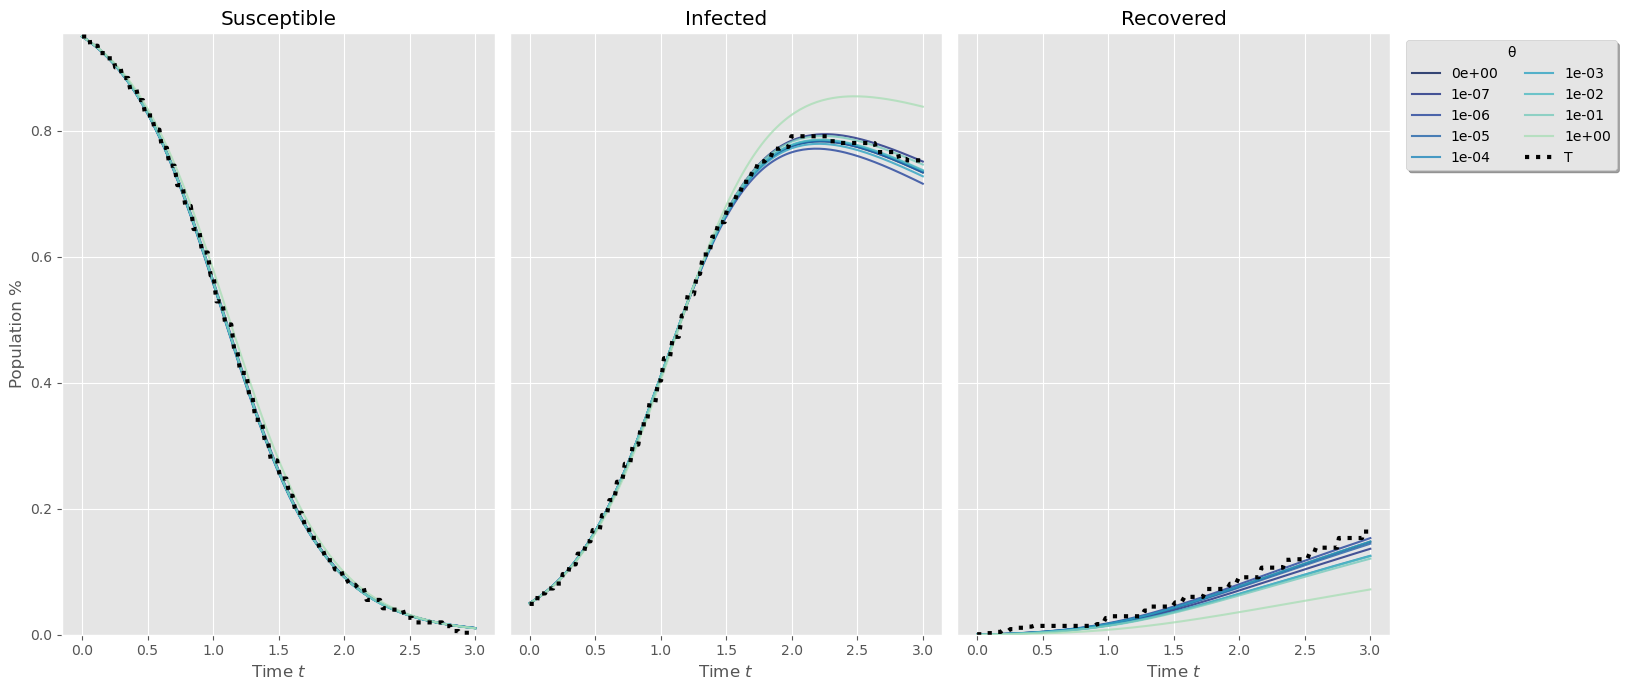

In [57]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – BFGS.pdf', bbox_inches='tight', pad_inches=0)

In [58]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,t_k,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,8,0.000332,1.933214,0.007048,0.092515,0.067470,0.126176,-0.007984,0.011400,0.000000,0.048520,0.073289,0.126176,0.007984
1.000000e-07,5,0.000496,2.118894,0.006997,0.084613,0.063076,0.242169,-0.039054,-0.005568,0.000000,0.095597,0.141659,0.242169,0.005568
1.000000e-06,4,0.000529,1.438294,0.007099,0.097223,0.075814,0.078454,0.017384,0.030127,0.000000,0.041988,0.049547,0.078454,0.017384
1.000000e-05,5,0.000374,1.712544,0.007050,0.090543,0.069421,0.252197,-0.012569,0.011186,0.000000,0.091984,0.145930,0.252197,0.011186
1.000000e-04,3,0.000773,1.766676,0.007049,0.078378,0.079908,0.243661,-0.035558,0.010185,0.000000,0.096468,0.142289,0.243661,0.010185
1.000000e-03,58,0.000393,2.707406,0.007067,0.093155,0.071243,0.158806,-0.001851,0.017343,0.501701,0.059333,0.092238,0.158806,0.001851
1.000000e-02,3,0.000844,1.681875,0.007045,0.077974,0.079339,-0.479589,-0.034191,0.011693,0.000000,0.175158,0.277676,0.479589,0.011693
1.000000e-01,9,0.001464,4.175969,0.007021,0.075050,0.075944,-0.123867,-0.042321,0.008692,0.000000,0.058293,0.075740,0.123867,0.008692
1.000000e+00,71,0.008392,2.119157,0.006714,0.042604,0.046995,0.104546,-0.164574,-0.050105,0.500000,0.106408,0.116225,0.164574,0.050105


In [59]:
print(np.around(Stats,6)[['it','time','β','γ','m','obj','norms-ℓ_2']].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & it & time & β & γ & m & obj & norms-ℓ_2 \\
\midrule
0.000000 & 8 & 1.933214 & 0.007048 & 0.092515 & 0.067470 & 0.000332 & 0.073289 \\
0.000000 & 5 & 2.118894 & 0.006997 & 0.084613 & 0.063076 & 0.000496 & 0.141659 \\
0.000001 & 4 & 1.438294 & 0.007099 & 0.097223 & 0.075814 & 0.000529 & 0.049547 \\
0.000010 & 5 & 1.712544 & 0.007050 & 0.090543 & 0.069421 & 0.000374 & 0.145930 \\
0.000100 & 3 & 1.766676 & 0.007049 & 0.078378 & 0.079908 & 0.000773 & 0.142289 \\
0.001000 & 58 & 2.707406 & 0.007067 & 0.093155 & 0.071243 & 0.000393 & 0.092238 \\
0.010000 & 3 & 1.681875 & 0.007045 & 0.077974 & 0.079339 & 0.000844 & 0.277676 \\
0.100000 & 9 & 4.175969 & 0.007021 & 0.075050 & 0.075944 & 0.001464 & 0.075740 \\
1.000000 & 71 & 2.119157 & 0.006714 & 0.042604 & 0.046995 & 0.008392 & 0.116225 \\
\bottomrule
\end{tabular}



In [60]:
Stats.to_pickle('Outputs/Regularisation – LMBFGS - Final.pkl') # To read back use pd.read_pickle(file_name)

---

# Joint plots

In [64]:
Stats  = pd.read_pickle('Outputs/Regularisation – LMBFGS - Final.pkl')
nmAPG_final = pd.read_pickle('Outputs/Regularisation – nmAPG - Final.pkl')
FISTA_final = pd.read_pickle('Outputs/Regularisation – FISTA - Final.pkl')
PGD_final   = pd.read_pickle('Outputs/Regularisation – PGD - Final.pkl')

In [66]:
PGD_final.head()

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,683,0.000182,12.976192,0.007011,0.104485,0.050259,0.012005,0.005427,0.003185,0.006872,0.007826,0.012005,0.003185
1.000000e-07,531,0.000186,10.615667,0.007015,0.101494,0.048307,1.761559,-0.012398,-0.011006,0.594988,1.017082,1.761559,0.011006
1.000000e-06,850,0.000293,14.352290,0.006949,0.107380,0.033207,-0.214336,-0.007855,-0.016856,0.079682,0.124212,0.214336,0.007855
1.000000e-05,972,0.000191,17.368802,0.007043,0.101730,0.053628,0.503064,0.000368,0.002799,0.168744,0.290449,0.503064,0.000368
1.000000e-04,837,0.000178,16.138311,0.007005,0.103968,0.047193,0.440456,-0.001440,-0.003523,0.148473,0.254307,0.440456,0.001440


Select colours:

In [67]:
from matplotlib   import colormaps
CMap = colormaps['YlGnBu']
colours_BFGS = CMap(linspace(0.3,1,14))

CMap = colormaps['YlOrBr']
colours_GD = CMap(linspace(0.3,1,14))

CMap = colormaps['RdPu']
colours_FISTA = CMap(linspace(0.3,1,14))

CMap = colormaps['BuGn']
colours_nmAPG = CMap(linspace(0.3,1,14))

Attained objective:

In [78]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

[]

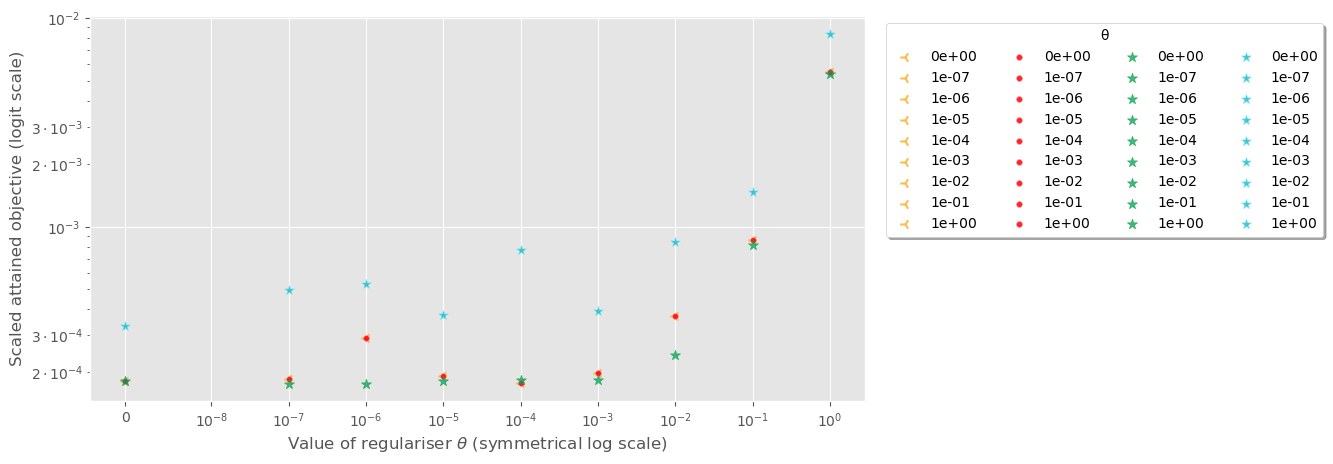

In [86]:
# Plot objective against θ
plt.figure(figsize=(10,5))
    
k = colours_GD.shape[0] - 1
for θ, fᵥ in PGD_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = 'gold',#'xkcd:pale gold',#colours_GD[k], 
            #markeredgecolor = "xkcd:robin's egg blue",
             alpha=0.95, #1, 
             marker='3', linestyle = '', markersize = 2*np.log(θ+10),#10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:pale gold', facecolor = colours_GD[2],#'gold',
                          #color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_FISTA.shape[0] - 1
for θ, fᵥ in FISTA_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_FISTA[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color = 'r', #colours_FISTA[k_row], 
                          #edgecolor = "xkcd:robin's egg blue",
                          edgecolor = "xkcd:rosa",
         alpha =0.85, marker='.', s = 30*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
k = colours_nmAPG.shape[0] - 1
for θ, fᵥ in nmAPG_final['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_BFGS[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:teal', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:green",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1 
    
k = colours_BFGS.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    '''plt.plot(θ, fᵥ, color = colours_BFGS[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='d', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))'''
    plt.scatter(θ, fᵥ, color='xkcd:turquoise blue', 
                          #color = colours_BFGS[k_row], 
                          edgecolor = "xkcd:robin's egg blue",
         alpha =0.75, marker='*', s = 25*np.log(θ+10), label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right", shadow=True, ncol=4, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$ (symmetrical log scale)');    plt.ylabel('Scaled attained objective (logit scale)')
plt.savefig('Outputs/Regularisation – Objectives.pdf', bbox_inches='tight', pad_inches=0)
plt.plot()

---